In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm
from glob import glob
from collections import defaultdict

import scipy.stats
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import matplotlib

import sys
sys.path.append("/home/icb/sergey.vilov/workspace/MLM/utils") 

from misc import model_alias, dna_models,model_bar_colors

matplotlib.rcParams.update({'font.size': 20})

In [2]:
data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/mlm/'

In [3]:
pred_dir =  data_dir + 'human_3utr/probs/'


models = ['DNABERT','DNBT-3UTR-RNA','NT-MS-v2-100M','NT-3UTR-RNA',
          'STSP-3UTR-RNA','STSP-3UTR-RNA-HS','STSP-3UTR-DNA','Zoo-AL']

In [4]:
strand_info = pd.read_csv(data_dir + 'UTR_coords/GRCh38_3_prime_UTR_clean-sorted.bed', sep='\t', header = None, names=['seq_name','strand'], usecols=[3,5]).set_index('seq_name').squeeze()

In [5]:
mapping = {'A':0,'C':1,'G':2,'T':3}

In [6]:
def get_model(glob_path,dna_model=False):
    
    res = {}
    for probas_file in glob(glob_path):
        with open(probas_file, 'rb') as f:
            fold_res = pickle.load(f)
            fold_res = {seq_name:{'probs':prob,'seq':seq} for seq_name,prob,seq in zip(fold_res['seq_names'],fold_res['probs'],fold_res['seqs'])
                        }
            res.update(fold_res)

    if dna_model:
        for seq_name in res.keys():
            if strand_info.loc[seq_name]=='-':
                #reverse complement to match rna sequences
                res[seq_name]['seq'] = reverse_complement(res[seq_name]['seq'])
                if res[seq_name]['probs'].ndim>1:
                    res[seq_name]['probs'] = res[seq_name]['probs'][::-1,[3,2,1,0]] #reverse complement probabilities
                else:
                    res[seq_name]['probs'] = res[seq_name]['probs'][::-1] #reverse complement probabilities
    return res

def read_fasta(fasta):

    seqs = defaultdict(str)
    
    with open(fasta, 'r') as f:
        for line in f:
            if line.startswith('>'):
                seq_name = line[1:].rstrip()
            else:
                seq = line.rstrip()
                seqs[seq_name] += seq.upper()
    return seqs

def reverse_complement(seq):
    '''
    Take sequence reverse complement
    '''
    compl_dict = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}
    compl_seq = ''.join([compl_dict.get(x,x) for x in seq])
    rev_seq = compl_seq[::-1]
    return rev_seq

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    a = a[~np.isnan(a)]
    n = len(a)
    m, se = np.nanmean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [7]:
res = {}
seq_names = []

for model in models:
    dna_model = model in dna_models
    model_probs = get_model(pred_dir + '/' + model_alias[model] + '/predictions*.pickle',dna_model)
    #for seq_name in model_probs.keys():
    #    model_probs[seq_name]['probs'] = [model_probs[seq_name]['probs'][i,mapping[c]] for i,c in enumerate(model_probs[seq_name]['seq'])]
    seq_names.append(set(model_probs.keys()))
    res[model] = model_probs
    print(f'{model} loaded, {len(model_probs)} sequences')

DNABERT loaded, 18134 sequences
DNBT-3UTR-RNA loaded, 18134 sequences
NT-MS-v2-100M loaded, 18178 sequences
NT-3UTR-RNA loaded, 18134 sequences
STSP-3UTR-RNA loaded, 18134 sequences
STSP-3UTR-RNA-HS loaded, 18134 sequences
STSP-3UTR-DNA loaded, 18178 sequences
Zoo-AL loaded, 18178 sequences


In [8]:
seq_names = set.intersection(*seq_names)

In [9]:
for seq_name in seq_names:
    seqs = set()
    for model in models:
        seqs.add(res[model][seq_name]['seq'].upper())
    assert len(seqs)==1

In [22]:
refmodel = 'Zoo-AL'

refprobs = {seq_name:res[refmodel][seq_name]['probs'][:,:4].flatten() for seq_name in seq_names}

In [23]:
all_probs = defaultdict(list)
#scores_all_seq = defaultdict(list)

for model in models:
    print(model)
    for seq_name in tqdm(seq_names):
        seq_probs = res[model][seq_name]['probs'][:,:4].flatten()
        all_probs[model].append(seq_probs)
        #if model!=refmodel:
        #    scores_all_seq[model].append(pearsonr(seq_probs, refprobs[seq_name]).statistic)
    all_probs[model] = np.hstack(all_probs[model])
    #print(np.nanmean(scores_all_seq[model]))

DNABERT


  0%|          | 0/18134 [00:00<?, ?it/s]

DNBT-3UTR-RNA


  0%|          | 0/18134 [00:00<?, ?it/s]

NT-MS-v2-100M


  0%|          | 0/18134 [00:00<?, ?it/s]

NT-3UTR-RNA


  0%|          | 0/18134 [00:00<?, ?it/s]

STSP-3UTR-RNA


  0%|          | 0/18134 [00:00<?, ?it/s]

STSP-3UTR-RNA-HS


  0%|          | 0/18134 [00:00<?, ?it/s]

STSP-3UTR-DNA


  0%|          | 0/18134 [00:00<?, ?it/s]

Zoo-AL


  0%|          | 0/18134 [00:00<?, ?it/s]

In [12]:
#res = [(model,*mean_confidence_interval(scores_all_seq[model])) for model in models if model!=refmodel]

In [13]:
res = []

for model in models:
    if model!='Zoo-AL':
        score = pearsonr(all_probs[model], all_probs['Zoo-AL'])
        ci = score.confidence_interval(confidence_level=0.95)
        res.append((model,score.statistic,(ci.high-ci.low)/2))

In [17]:
res_df = pd.DataFrame(res,columns=['model','pearson_mean','pearson_ci']).set_index('model')

res_df

,pearson_mean,pearson_ci
model,,
DNABERT,0.425022,0.000141
DNBT-3UTR-RNA,0.424127,0.000141
NT-MS-v2-100M,0.348599,0.000151
NT-3UTR-RNA,0.539204,0.000122
STSP-3UTR-RNA,0.400016,0.000144
STSP-3UTR-RNA-HS,0.296638,0.000157
STSP-3UTR-DNA,0.396562,0.000145


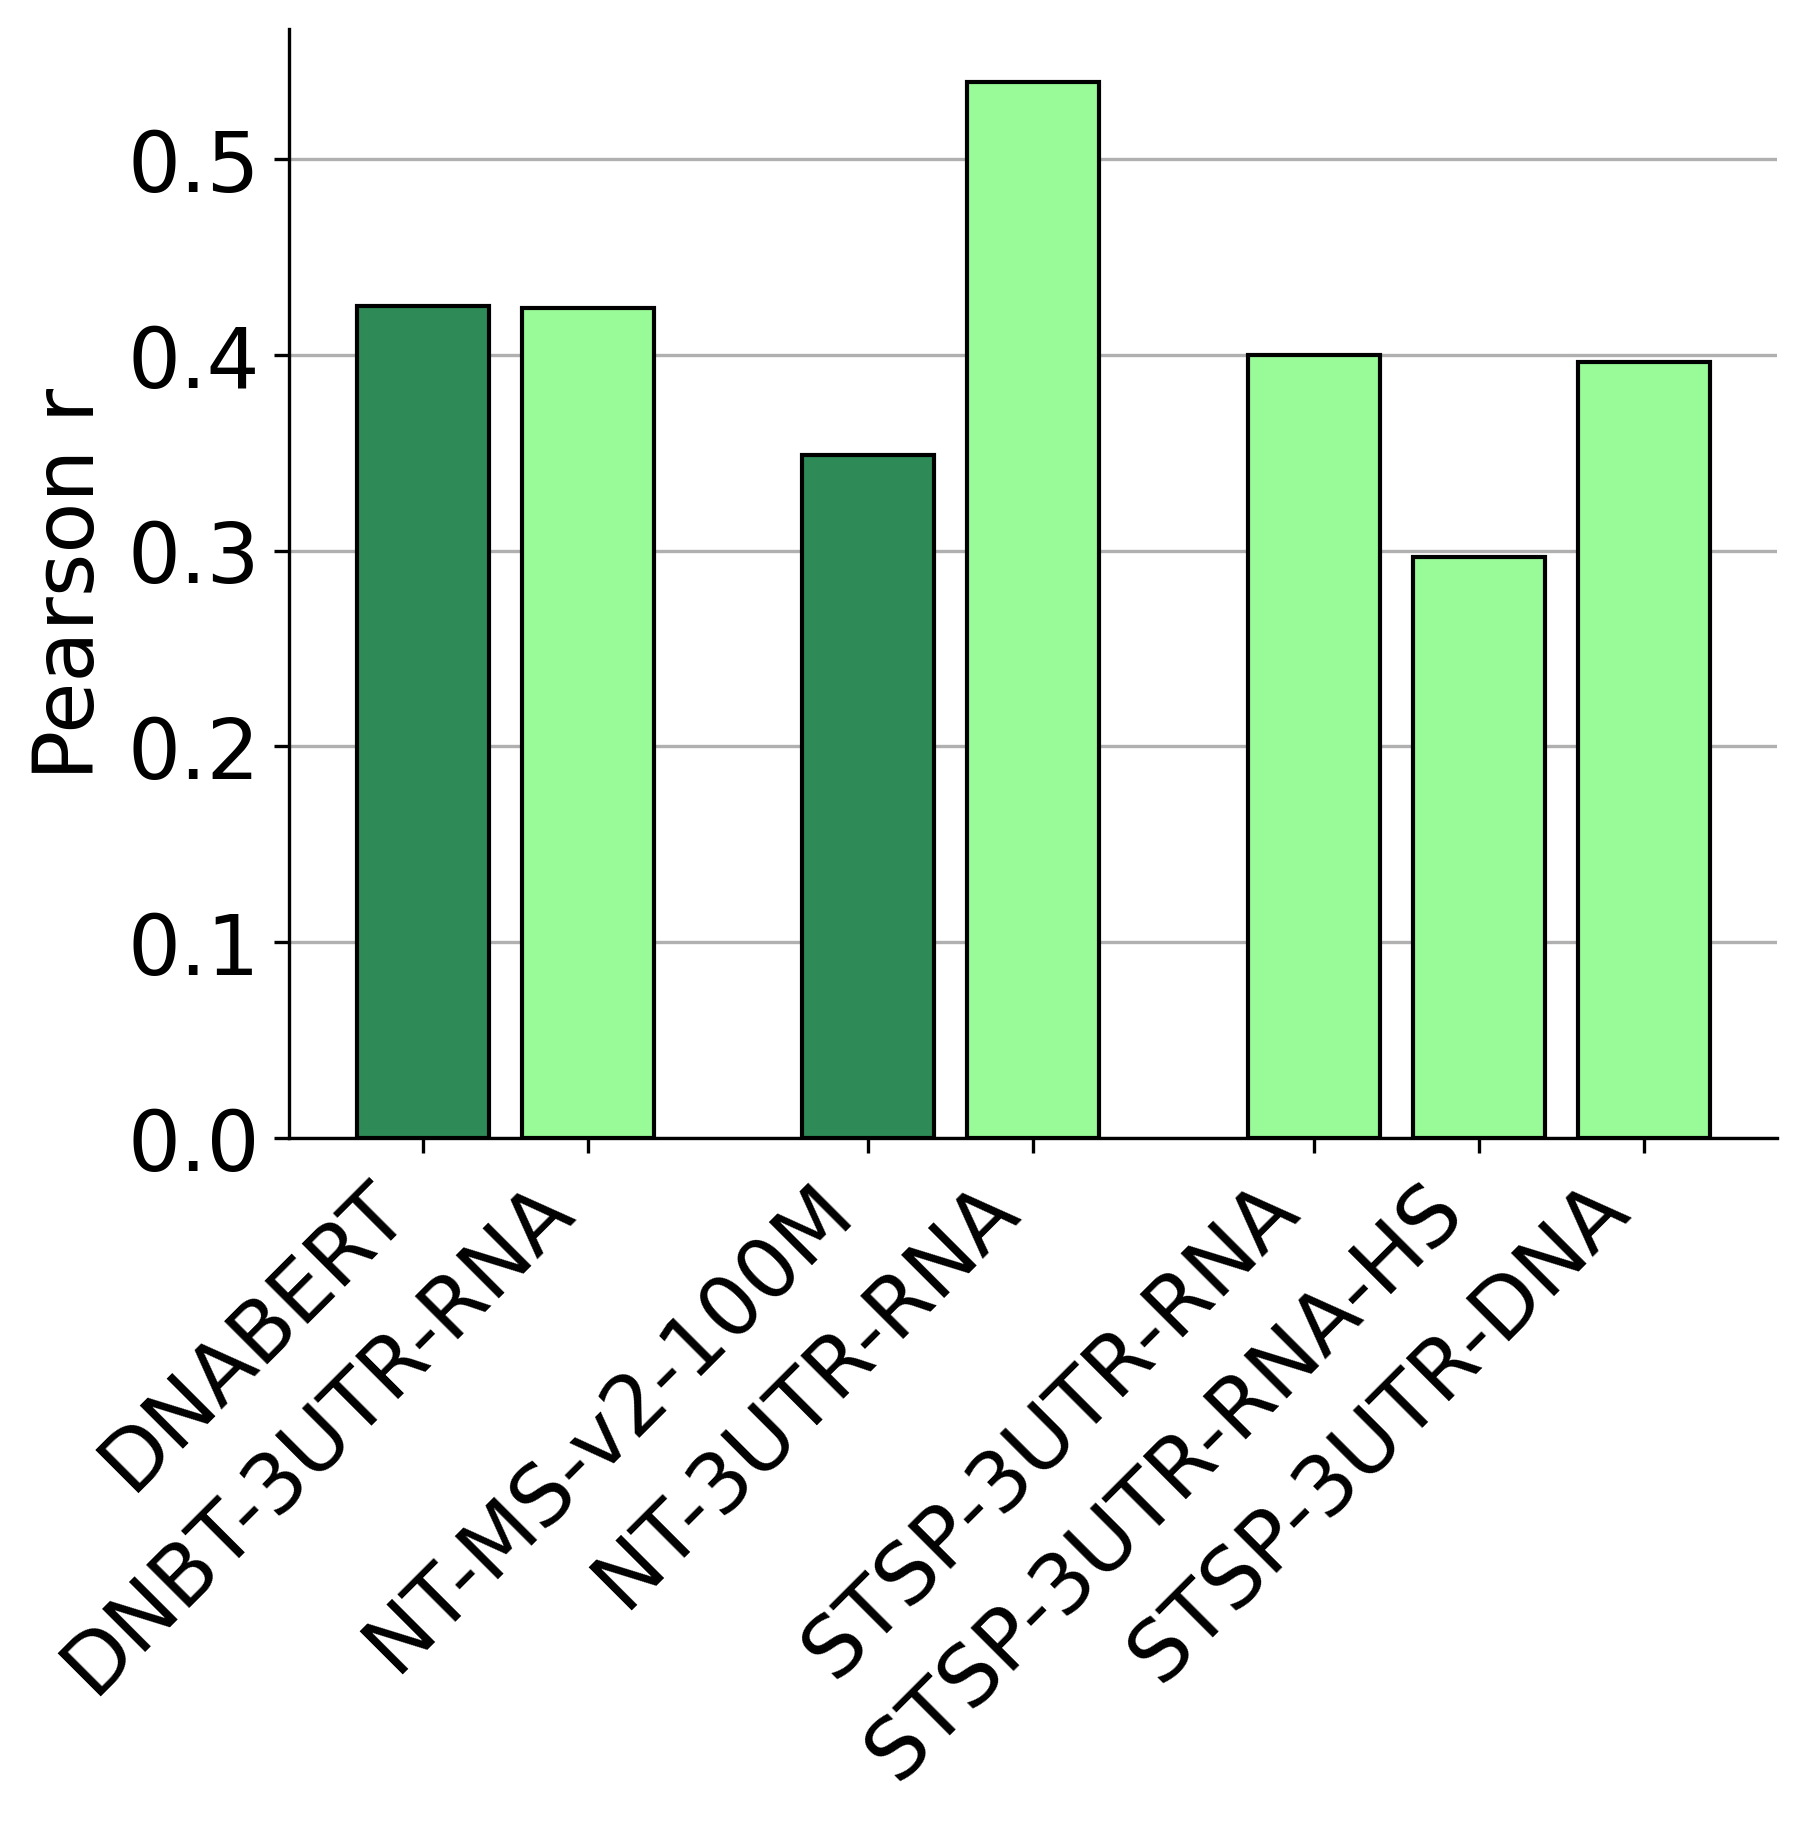

In [22]:
fig, ax = plt.subplots(dpi=300)

offset = 0
xticks = []

for idx, (model, row) in enumerate(res_df.iterrows()):
    if model in ('DNABERT2','NT-MS-v2-100M','STSP-3UTR-RNA','DNABERT','PhyloP-100way'):
        offset+=0.7
    ax.bar(offset+idx, row.pearson_mean, yerr=row.pearson_ci, color=model_bar_colors[model], edgecolor='black')
    xticks.append(offset+idx)
        
ax.set_ylabel(f'Pearson r')
ax.set_xticks(xticks, res_df.index, rotation=45, ha="right");

ax.grid(axis='y')
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [26]:
res = []

for model in models:
    if model!='Zoo-AL':
        score = pearsonr(all_probs[model][:512*4], all_probs['Zoo-AL'][:512*4])
        ci = score.confidence_interval(confidence_level=0.95)
        res.append((model,score.statistic,(ci.high-ci.low)/2))

res

[('DNABERT', 0.33583974547859513, 0.03843693682979363),
 ('DNBT-3UTR-RNA', 0.3591303371746011, 0.03773684065312466),
 ('NT-MS-v2-100M', 0.17614804903265127, 0.04197261884663084),
 ('NT-3UTR-RNA', 0.5467584398317757, 0.030382638271612916),
 ('STSP-3UTR-RNA', 0.38371737485868096, 0.03694680780576384),
 ('STSP-3UTR-RNA-HS', 0.3225112512869359, 0.03881645215410326),
 ('STSP-3UTR-DNA', 0.3612869650717653, 0.03766963823727654)]